# Converting OD zones into Districts

In [1]:
%matplotlib inline
from scipy.stats import gamma 
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import numpy as np
import pandas as pd
import pyreadstat as prs
mpl.style.use('dark_background')

In [4]:
# Load 2017 RMSP Origin-Destinatin survey microdata
df, meta = prs.read_sav('../../data/raw/OD_2017.sav')
print("Number of traves:", len(df))

Number of traves: 183092


In [5]:
# Estimate the travel matrix using data for zones
num_zones = 517
M = np.zeros((num_zones,num_zones))
for j in range(num_zones):
    for k in range(num_zones):
        M[j,k] += ((df.zona_o==j+1)&(df.zona_d==k+1)).sum()

KeyboardInterrupt: 

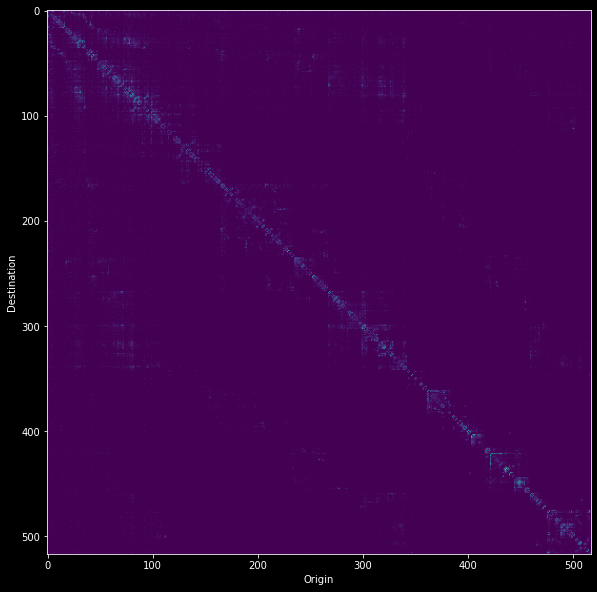

In [6]:
# Plot 2D histogram
fig = plt.figure(figsize=(10,10))
plt.imshow(M-np.diag(np.diag(M))) # alternatively, fix vmax at 200
plt.xlabel('Origin')
plt.ylabel('Destination');

In [7]:
# Load zone to distrivt dictionary file
dist_df = pd.read_csv('distritos.csv', sep=';')
num_dist = len(np.unique(dist_df.cod_distrito)) # no. of districts

In [9]:
dist_df

,zona,nome,cod_municipio,municipio,cod_distrito,distrito,popu
0,1,Sé,36,São Paulo,80,Sé,3262
1,2,Parque Dom Pedro,36,São Paulo,80,Sé,5695
2,3,Praça João Mendes,36,São Paulo,80,Sé,17130
3,4,Ladeira da Memória,36,São Paulo,67,República,24089
4,5,República,36,São Paulo,67,República,14956
...,...,...,...,...,...,...,...
512,513,Quatro Encruzilhadas,17,Itapevi,113,Itapevi,3587
513,514,Itapevi,17,Itapevi,113,Itapevi,104626
514,515,Amador Bueno,17,Itapevi,113,Itapevi,120821
515,516,Santana de Parnaíba,31,Santana de Parnaíba,127,Santana de Parnaíba,131608


In [8]:
# Extract travel matrix for zones (highly inefficient)
P = np.zeros((num_dist,num_dist))
for i in range(num_dist):
    for j in range(num_dist):
        P[i,j] = M[np.ix_(dist_df.zona[dist_df.cod_distrito==i+1]-1,dist_df.zona[dist_df.cod_distrito==j+1]-1)].sum()

KeyboardInterrupt: 

In [13]:
# Sanity check
P[79,66] == M[0,3] + M[1,3] + M[2,3] + M[0,4] + M[1,4] + M[2,4] + M[0,5] + M[1,5] + M[2,5]

True

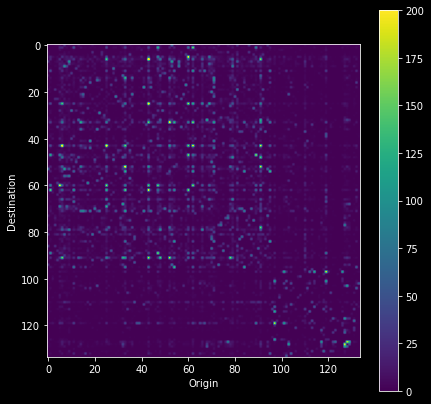

In [14]:
# Show 2D histogram
fig = plt.figure(figsize=(7,7))
im = plt.imshow(P-np.diag(np.diag(P)),vmax=200)
plt.xlabel('Origin')
plt.ylabel('Destination');
fig.colorbar(im);

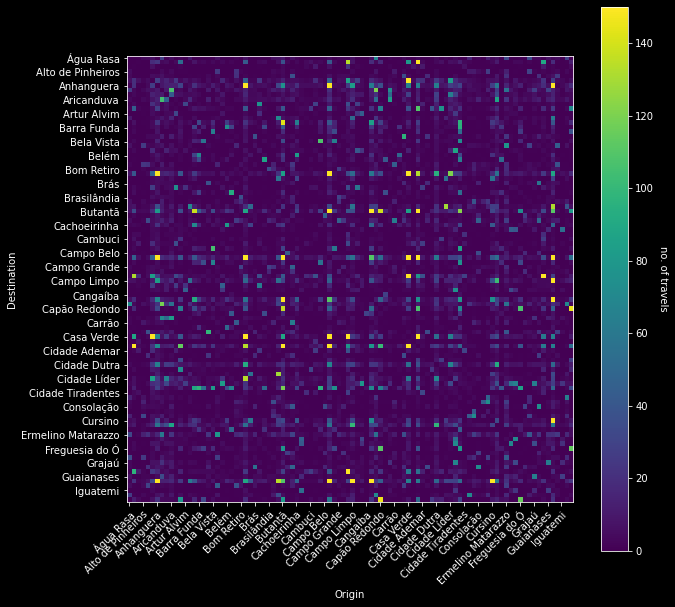

In [15]:
# Showing only the city of SP
# Add district names to axis
sp_lim = int(dist_df.cod_distrito[dist_df.cod_municipio == 36].max())
P_SP = P[:sp_lim,:sp_lim]
fig, ax = plt.subplots(figsize=(10,10))
#fig = fig.figure(figsize=(7,7))
im = ax.imshow(P_SP-np.diag(np.diag(P_SP)),vmax=150)
plt.xlabel('Origin')
plt.ylabel('Destination')
#ax.set_xticks(np.arange(P_SP.shape[1]+1)-.5, minor=True)
ax.set_xticks(np.arange(0,sp_lim,3))
ax.set_xticklabels([ dist_df.distrito[dist_df.cod_distrito == i+1].unique()[0] for i in range(num_dist) ])
ax.set_yticks(np.arange(0,sp_lim,3)) #np.arange(P_SP.shape[0]+1)-.5, minor=True)
ax.set_yticklabels([ dist_df.distrito[dist_df.cod_distrito == i+1].unique()[0] for i in range(num_dist) ])
ax.tick_params(which="minor", bottom=False, left=False)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("no. of travels", rotation=-90, va="bottom")
plt.show()

In [4]:
import geopandas as gpd
# Load shape files with city map and district divisions
gdf = gpd.read_file('DEINFO_DISTRITO.shp', SHAPE_RESTORE_SHX )
# Sanity check
gdf.COD_DIST.unique().size == sp_lim

DriverError: Unable to open DEINFO_DISTRITO.shx or DEINFO_DISTRITO.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

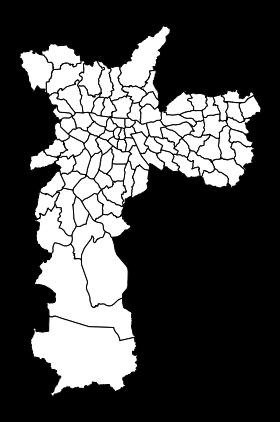

In [17]:
# plot map
p = gdf.plot(color='white', edgecolor='black',figsize=(5,7.5));
p.axis('off');

In [21]:
# Obtain population district -- Need to convert district names in shapes file to corresponding name in csv
from unidecode import unidecode
# List all names in csv file
names = np.unique([ s for s in dist_df.distrito.array ])
# Array of population sizes
popsizes = np.zeros(sp_lim)
# For each district name in shapes file
for i,name in enumerate(gdf.NOME_DIST.array):
    # Find equivalent name in dist_df 
    d_name = '*** not found ***'
    for dist_name in names:
        if unidecode(dist_name).upper().replace('JARDIM','JD').replace('CIDADE','CID') == name:
            d_name = dist_name
            break
    if d_name == '*** not found ***':        
        break
    # collect population size (some values are missing, 'coerce' it to NaN -- equiv. to zero when summing out)
    popsizes[i] = pd.to_numeric(dist_df.popu[dist_df.distrito == d_name],errors='coerce').sum()

gdf['POP'] = popsizes
gdf

,CLASSID,FEATID,REVISIONNU,NOME_DIST,SIGLA_DIST,COD_DIST,COD_SUB,DATA_CRIAC,USUARIO_ID,geometry,POP
0,4.0,8583485.0,1.0,JOSE BONIFACIO,JBO,47,27,2007-03-19,0.0,"POLYGON ((352436.869 7394174.148, 352450.740 7...",134096.0
1,4.0,8583484.0,1.0,JD SAO LUIS,JDS,46,18,2007-03-19,0.0,"POLYGON ((320696.639 7383620.282, 320699.486 7...",288138.0
2,4.0,8583445.0,1.0,ARTUR ALVIM,AAL,5,21,2007-03-19,0.0,"POLYGON ((349461.276 7397764.525, 349461.935 7...",101415.0
3,4.0,8583479.0,1.0,JAGUARA,JAG,40,08,2007-03-19,0.0,"POLYGON ((320731.080 7400614.592, 320732.386 7...",24154.0
4,4.0,8583437.0,1.0,VILA PRUDENTE,VPR,93,29,2007-03-19,0.0,"POLYGON ((338651.039 7392203.484, 338654.034 7...",104643.0
...,...,...,...,...,...,...,...,...,...,...,...
91,4.0,8583433.0,1.0,VILA MARIA,VMR,89,07,2007-03-19,0.0,"POLYGON ((338228.823 7397145.610, 338216.895 7...",113811.0
92,4.0,8583434.0,1.0,VILA MARIANA,VMN,90,12,2007-03-19,0.0,"POLYGON ((331606.384 7389277.797, 331607.340 7...",131989.0
93,4.0,8583435.0,1.0,VILA MATILDE,VMT,91,21,2007-03-19,0.0,"POLYGON ((341994.993 7396441.620, 341979.394 7...",105515.0
94,4.0,8583412.0,1.0,SANTA CECILIA,SCE,69,09,2007-03-19,0.0,"POLYGON ((330220.609 7396091.962, 330226.819 7...",87733.0


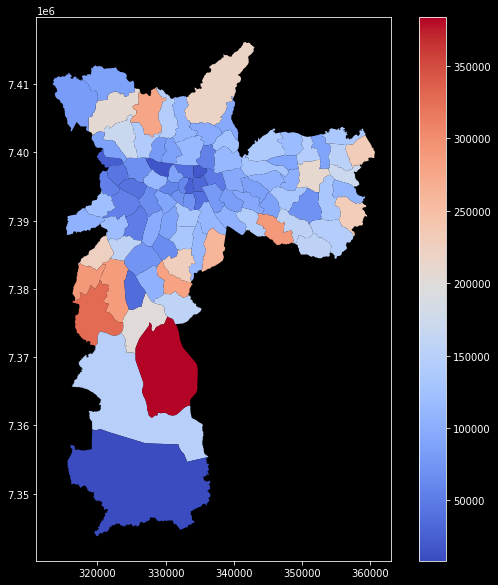

In [22]:
# Now plot 2D histogram with population sizes
gdf.plot(column='POP', cmap='coolwarm', legend=True, figsize=(10, 10));
# plt.title('Domícilios');